# 1 - DQN

## DQN CPU implementation (~2mins per episode)

In [7]:
# training_code.py

import random
import numpy as np
from collections import deque
from scipy.spatial import cKDTree

import torch
import torch.nn as nn
import torch.optim as optim

class DQNAgent(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNAgent, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, action_size)
        
        # Initialize weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)

class SugarscapeEnvironmentDQN:
    def __init__(self, width, height, num_agents, seed=None):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.seed = seed

        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)
            torch.manual_seed(self.seed)

        self.params = {
            'max_sugar': 5,
            'growth_rate': 1,
            'sugar_peak_frequency': 0.05,
            'sugar_peak_spread': 3,
            'job_center_duration': (20, 50),
            'vision_range': 1,
            'message_expiry': 15,
            'max_messages': 5,
            'exploration_probability': 0.1
        }

        self.state_size = 5 + (2 * self.params['vision_range'] + 1) ** 2 + (3 * self.params['max_messages'])
        self.action_size = 5  # Up, Down, Left, Right, Stay
        self.q_network = DQNAgent(self.state_size, self.action_size)
        self.target_network = DQNAgent(self.state_size, self.action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=1e-3)
        self.criterion = nn.MSELoss()
        self.replay_buffer = deque(maxlen=10000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon_start = 1.0
        self.epsilon_end = 0.1
        self.epsilon_decay = 1000
        self.epsilon = self.epsilon_start

    def create_initial_sugar_peaks(self, num_peaks=2):
        self.job_centers = []
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x_grid, y_grid = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x_grid - center['x']) ** 2 + (y_grid - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(-distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2))
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        self.sugar = np.round(self.sugar).astype(int)

    def initialize_agents(self):
        agents = []
        available_positions = set((x, y) for x in range(self.width) for y in range(self.height))
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    def create_agent(self, id, x, y):
        return {
            'id': id,
            'x': x,
            'y': y,
            'sugar': np.random.randint(20, 50),
            'metabolism': np.random.randint(1, 3),
            'vision': self.params['vision_range'],
            'messages': deque(maxlen=self.params['max_messages']),
            'destination': None,
            'memory': deque(maxlen=10),
            'path': [],
            'age': 0
        }

    def reset_environment(self):
        self.timestep = 0
        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []
        self.replay_buffer.clear()

    def run_training(self, total_episodes=1000, max_timesteps=1000):
        for episode in range(total_episodes):
            self.reset_environment()
            self.episode = episode
            self.epsilon = max(self.epsilon_end, self.epsilon_start - episode / self.epsilon_decay)
            for t in range(max_timesteps):
                self.step()
                if len(self.replay_buffer) >= self.batch_size:
                    loss = self.train_dqn()
                    if t % 100 == 0:
                        print(f"Episode: {episode}, Timestep: {t}, Loss: {loss:.4f}, Epsilon: {self.epsilon:.4f}")
                # Update target network periodically
                if self.timestep % 100 == 0:
                    self.target_network.load_state_dict(self.q_network.state_dict())
                self.timestep += 1  # Increment timestep here

            if (episode + 1) % 100 == 0:
                print(f"Completed Episode: {episode + 1}")
                # Save model every 100 episodes
                torch.save(self.q_network.state_dict(), f'dqn_episode_{episode + 1}.pth')

    def get_state(self, agent):
        x, y = agent['x'], agent['y']
        sugar = agent['sugar'] / 100  # Normalize sugar level
        metabolism = agent['metabolism'] / 5  # Normalize metabolism
        vision = agent['vision'] / 5  # Normalize vision

        # Extract sugar levels within vision range
        vision_range = agent['vision']
        y_min = max(0, y - vision_range)
        y_max = min(self.height, y + vision_range + 1)
        x_min = max(0, x - vision_range)
        x_max = min(self.width, x + vision_range + 1)
        sugar_map = self.sugar[y_min:y_max, x_min:x_max]

        # Pad the sugar map to a fixed size
        expected_size = (2 * vision_range + 1, 2 * vision_range + 1)
        pad_h = expected_size[0] - sugar_map.shape[0]
        pad_w = expected_size[1] - sugar_map.shape[1]

        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        padded_sugar_map = np.pad(sugar_map, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)
        sugar_map_flat = padded_sugar_map.flatten() / self.params['max_sugar']  # Normalize sugar levels

        # Encode messages
        N = self.params['max_messages']  # Number of messages to encode
        messages = list(agent['messages'])[-N:]  # Get the last N messages
        message_features = []
        for msg in messages:
            # Normalize message coordinates relative to grid size
            msg_x = msg['x'] / self.width
            msg_y = msg['y'] / self.height
            msg_sugar = msg['sugar_amount'] / self.params['max_sugar']
            message_features.extend([msg_x, msg_y, msg_sugar])
        # Pad remaining messages with zeros if fewer than N
        while len(message_features) < 3 * N:
            message_features.extend([0.0, 0.0, 0.0])

        state = np.concatenate(([x / self.width, y / self.height, sugar, metabolism, vision], sugar_map_flat, message_features))
        return state

    def select_action(self, state, valid_actions):
        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            # Mask invalid actions
            mask = torch.full((self.action_size,), -float('inf'))
            mask[valid_actions] = 0
            masked_q = q_values + mask
            return masked_q.argmax().item()

    def get_valid_actions(self, agent):
        actions = []
        x, y = agent['x'], agent['y']
        possible_moves = {
            0: (x, y - 1),  # Up
            1: (x, y + 1),  # Down
            2: (x - 1, y),  # Left
            3: (x + 1, y),  # Right
            4: (x, y)       # Stay
        }
        for action, (nx, ny) in possible_moves.items():
            if 0 <= nx < self.width and 0 <= ny < self.height:
                if (nx, ny) not in self.agent_positions or (nx, ny) == (x, y):
                    actions.append(action)
        return actions

    def move_agent(self, agent, action):
        x, y = agent['x'], agent['y']
        possible_moves = {
            0: (x, y - 1),  # Up
            1: (x, y + 1),  # Down
            2: (x - 1, y),  # Left
            3: (x + 1, y),  # Right
            4: (x, y)       # Stay
        }
        nx, ny = possible_moves[action]
        if (0 <= nx < self.width and 0 <= ny < self.height and
                ((nx, ny) not in self.agent_positions or (nx, ny) == (x, y))):
            self.agent_positions.remove((x, y))
            agent['x'], agent['y'] = nx, ny
            agent['path'].append((agent['x'], agent['y']))
            self.agent_positions.add((nx, ny))

    def collect_sugar_and_update_agent(self, agent):
        collected_sugar = self.sugar[agent['y'], agent['x']]
        agent['sugar'] += collected_sugar
        self.sugar[agent['y'], agent['x']] = 0
        agent['sugar'] -= agent['metabolism']
        agent['age'] += 1

    def broadcast_messages(self):
        if not self.agents:
            return  # No agents to broadcast

        positions = np.array([[agent['x'], agent['y']] for agent in self.agents])
        tree = cKDTree(positions)

        for i, agent in enumerate(self.agents):
            # Identify visible sugar peaks
            visible_sugar = self.get_visible_sugar(agent)
            sugar_locations = np.argwhere(visible_sugar > 0)
            messages = []
            for loc in sugar_locations:
                msg_x = agent['x'] + loc[1] - agent['vision']
                msg_y = agent['y'] + loc[0] - agent['vision']
                # Ensure message coordinates are within grid
                msg_x = int(np.clip(msg_x, 0, self.width - 1))
                msg_y = int(np.clip(msg_y, 0, self.height - 1))
                msg = {
                    'sender_id': agent['id'],
                    'timestep': self.timestep,
                    'sugar_amount': self.sugar[msg_y, msg_x],
                    'x': msg_x,
                    'y': msg_y
                }
                messages.append(msg)

            # Broadcast to neighbors within broadcast_radius
            radius = 5  # Fixed broadcast radius
            neighbors = tree.query_ball_point([agent['x'], agent['y']], radius)
            for neighbor_idx in neighbors:
                if neighbor_idx != i:
                    for msg in messages:
                        self.agents[neighbor_idx]['messages'].append(msg)

    def get_visible_sugar(self, agent):
        x, y = agent['x'], agent['y']
        vision = agent['vision']
        y_min = max(0, y - vision)
        y_max = min(self.height, y + vision + 1)
        x_min = max(0, x - vision)
        x_max = min(self.width, x + vision + 1)
        visible_area = self.sugar[y_min:y_max, x_min:x_max]
        return visible_area

    def step(self):
        # Update job centers and sugar landscape
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Broadcast messages
        self.broadcast_messages()

        # For each agent, select action and collect experience
        for agent in self.agents:
            state = self.get_state(agent)
            valid_actions = self.get_valid_actions(agent)
            if not valid_actions:
                continue  # Skip if no valid actions
            action = self.select_action(state, valid_actions)
            prev_sugar = agent['sugar']
            self.move_agent(agent, action)
            self.collect_sugar_and_update_agent(agent)
            next_state = self.get_state(agent)
            reward = agent['sugar'] - prev_sugar  # Reward is the change in sugar
            done = agent['sugar'] <= 0
            self.replay_buffer.append((state, action, reward, next_state, done))

        # Handle agent death
        alive_agents = []
        for agent in self.agents:
            if agent['sugar'] <= 0:
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        # Replenish agents
        self.replenish_agents()

    def train_dqn(self):
        experiences = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)

        states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(np.array(next_states))
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Current Q-values
        current_q = self.q_network(states).gather(1, actions)

        # Target Q-values
        with torch.no_grad():
            max_next_q = self.target_network(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + (self.gamma * max_next_q * (1 - dones))

        # Compute loss
        loss = self.criterion(current_q, target_q)

        # Optimize the Q-network
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()

        return loss.item()

    def replenish_agents(self):
        while len(self.agents) < self.num_agents:
            x, y = random.randint(0, self.width - 1), random.randint(0, self.height - 1)
            if (x, y) not in self.agent_positions:
                agent_id = max([agent['id'] for agent in self.agents] + [0]) + 1
                new_agent = self.create_agent(agent_id, x, y)
                self.agent_positions.add((x, y))
                self.agents.append(new_agent)

    # Exclude visualization methods

# Initialize and run training
if __name__ == "__main__":
    seed = 42  # Set a seed for reproducibility
    env = SugarscapeEnvironmentDQN(width=30, height=30, num_agents=400, seed=seed)
    TOTAL_EPISODES = 1000
    MAX_TIMESTEPS = 1000
    env.run_training(total_episodes=TOTAL_EPISODES, max_timesteps=MAX_TIMESTEPS)

    # Save the final model
    torch.save(env.q_network.state_dict(), 'checkpoints/dqn_final.pth')
    torch.save(env.target_network.state_dict(), 'dqn_target_network_final.pth')

    print("\nTraining completed and model saved.")


C:\Users\Neo\AppData\Local\Temp\ipykernel_32604\3993727961.py:344: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1)


Episode: 0, Timestep: 0, Loss: 1.6222, Epsilon: 1.0000
Episode: 0, Timestep: 100, Loss: 0.2857, Epsilon: 1.0000
Episode: 0, Timestep: 200, Loss: 0.1133, Epsilon: 1.0000
Episode: 0, Timestep: 300, Loss: 0.5021, Epsilon: 1.0000
Episode: 0, Timestep: 400, Loss: 0.1275, Epsilon: 1.0000
Episode: 0, Timestep: 500, Loss: 0.8939, Epsilon: 1.0000
Episode: 0, Timestep: 600, Loss: 1.8718, Epsilon: 1.0000
Episode: 0, Timestep: 700, Loss: 1.2199, Epsilon: 1.0000
Episode: 0, Timestep: 800, Loss: 0.4083, Epsilon: 1.0000
Episode: 0, Timestep: 900, Loss: 2.5941, Epsilon: 1.0000
Episode: 1, Timestep: 0, Loss: 0.9833, Epsilon: 0.9999
Episode: 1, Timestep: 100, Loss: 0.5058, Epsilon: 0.9999
Episode: 1, Timestep: 200, Loss: 0.5384, Epsilon: 0.9999
Episode: 1, Timestep: 300, Loss: 1.7507, Epsilon: 0.9999
Episode: 1, Timestep: 400, Loss: 3.8407, Epsilon: 0.9999
Episode: 1, Timestep: 500, Loss: 1.7184, Epsilon: 0.9999
Episode: 1, Timestep: 600, Loss: 3.2761, Epsilon: 0.9999
Episode: 1, Timestep: 700, Loss: 0.

KeyboardInterrupt: 

## DQN GPU implementation (~roughly 50s per episode)

In [1]:
# training_code.py

import random
import numpy as np
from collections import deque
from scipy.spatial import cKDTree
import csv  # For logging data into CSV

import torch
import torch.nn as nn
import torch.optim as optim

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQNAgent(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNAgent, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, action_size)
        
        # Initialize weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)
        
        self.to(device)  # Move the model to the device
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)

class SugarscapeEnvironmentDQN:
    def __init__(self, width, height, num_agents, seed=None):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.seed = seed

        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)
            torch.manual_seed(self.seed)

        self.params = {
            'max_sugar': 5,
            'growth_rate': 1,
            'sugar_peak_frequency': 0.05,
            'sugar_peak_spread': 3,
            'job_center_duration': (20, 50),
            'vision_range': 1,
            'message_expiry': 15,
            'max_messages': 5,
            'exploration_probability': 0.1
        }

        self.state_size = 5 + (2 * self.params['vision_range'] + 1) ** 2 + (3 * self.params['max_messages'])
        self.action_size = 5  # Up, Down, Left, Right, Stay
        self.q_network = DQNAgent(self.state_size, self.action_size).to(device)
        self.target_network = DQNAgent(self.state_size, self.action_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=1e-5)
        self.criterion = nn.MSELoss()
        self.replay_buffer = deque(maxlen=10000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon_start = 1.0
        self.epsilon_end = 0.1
        self.epsilon_decay = 10000
        self.epsilon = self.epsilon_start

    def create_initial_sugar_peaks(self, num_peaks=2):
        self.job_centers = []
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x_grid, y_grid = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x_grid - center['x']) ** 2 + (y_grid - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(-distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2))
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        self.sugar = np.round(self.sugar).astype(int)

    def initialize_agents(self):
        agents = []
        available_positions = set((x, y) for x in range(self.width) for y in range(self.height))
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    def create_agent(self, id, x, y):
        return {
            'id': id,
            'x': x,
            'y': y,
            'sugar': np.random.randint(20, 50),
            'metabolism': np.random.randint(1, 3),
            'vision': self.params['vision_range'],
            'messages': deque(maxlen=self.params['max_messages']),
            'destination': None,
            'memory': deque(maxlen=10),
            'path': [],
            'age': 0
        }

    def reset_environment(self):
        self.timestep = 0
        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []
        self.replay_buffer.clear()

    def run_training(self, total_episodes=1000, max_timesteps=1000):
        # Open CSV file for writing
        with open('training_log.csv', mode='w', newline='') as csv_file:
            fieldnames = ['Episode', 'Loss', 'TotalReward', 'Epsilon', 'FinalAgentPopulation']
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            writer.writeheader()

            for episode in range(total_episodes):
                self.reset_environment()
                self.episode = episode
                self.epsilon = max(self.epsilon_end, self.epsilon_start - episode / self.epsilon_decay)
                total_reward = 0  # Initialize total reward for the episode
                losses = []  # Collect losses for the episode

                for t in range(max_timesteps):
                    timestep_reward = self.step()  # Modify step() to return total rewards
                    total_reward += timestep_reward

                    if len(self.replay_buffer) >= self.batch_size:
                        loss = self.train_dqn()
                        losses.append(loss)
                        if t % 100 == 0:
                            print(f"Episode: {episode + 1}, Timestep: {t}, Loss: {loss:.4f}, Epsilon: {self.epsilon:.4f}")
                    else:
                        loss = None  # No loss computed yet

                    # Update target network periodically
                    if self.timestep % 100 == 0:
                        self.target_network.load_state_dict(self.q_network.state_dict())
                    self.timestep += 1  # Increment timestep here

                # Calculate average loss for the episode
                avg_loss = sum(losses) / len(losses) if losses else 0

                # Log data for the episode
                final_agent_population = len(self.agents)
                log_entry = {
                    'Episode': episode + 1,
                    'Loss': avg_loss,
                    'TotalReward': total_reward,
                    'Epsilon': self.epsilon,
                    'FinalAgentPopulation': final_agent_population
                }
                writer.writerow(log_entry)

                print(f"Episode {episode + 1} completed. Total Reward: {total_reward:.2f}, Average Loss: {avg_loss:.4f}, Final Agent Population: {final_agent_population}")

                if (episode + 1) % 100 == 0:
                    print(f"Completed Episode: {episode + 1}")
                    # Save model every 100 episodes
                    torch.save(self.q_network.state_dict(), f'dqn_episode_{episode + 1}.pth')

        print("\nTraining completed and log saved to 'training_log.csv'.")

    def get_state(self, agent):
        x, y = agent['x'], agent['y']
        sugar = agent['sugar'] / 100  # Normalize sugar level
        metabolism = agent['metabolism'] / 5  # Normalize metabolism
        vision = agent['vision'] / 5  # Normalize vision

        # Extract sugar levels within vision range
        vision_range = agent['vision']
        y_min = max(0, y - vision_range)
        y_max = min(self.height, y + vision_range + 1)
        x_min = max(0, x - vision_range)
        x_max = min(self.width, x + vision_range + 1)
        sugar_map = self.sugar[y_min:y_max, x_min:x_max]

        # Pad the sugar map to a fixed size
        expected_size = (2 * vision_range + 1, 2 * vision_range + 1)
        pad_h = expected_size[0] - sugar_map.shape[0]
        pad_w = expected_size[1] - sugar_map.shape[1]

        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        padded_sugar_map = np.pad(sugar_map, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)
        sugar_map_flat = padded_sugar_map.flatten() / self.params['max_sugar']

        # Encode messages
        N = self.params['max_messages']
        messages = list(agent['messages'])[-N:]
        message_features = []
        for msg in messages:
            # Normalize message coordinates relative to grid size
            msg_x = msg['x'] / self.width
            msg_y = msg['y'] / self.height
            msg_sugar = msg['sugar_amount'] / self.params['max_sugar']
            message_features.extend([msg_x, msg_y, msg_sugar])
        # Pad remaining messages with zeros if fewer than N
        while len(message_features) < 3 * N:
            message_features.extend([0.0, 0.0, 0.0])

        state = np.concatenate(([x / self.width, y / self.height, sugar, metabolism, vision], sugar_map_flat, message_features))
        return state

    def select_action(self, state, valid_actions):
        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            # Mask invalid actions
            mask = torch.full((self.action_size,), -float('inf')).to(device)
            mask[valid_actions] = 0
            masked_q = q_values + mask
            return masked_q.argmax().item()

    def get_valid_actions(self, agent):
        actions = []
        x, y = agent['x'], agent['y']
        possible_moves = {
            0: (x, y - 1),  # Up
            1: (x, y + 1),  # Down
            2: (x - 1, y),  # Left
            3: (x + 1, y),  # Right
            4: (x, y)       # Stay
        }
        for action, (nx, ny) in possible_moves.items():
            if 0 <= nx < self.width and 0 <= ny < self.height:
                if (nx, ny) not in self.agent_positions or (nx, ny) == (x, y):
                    actions.append(action)
        return actions

    def move_agent(self, agent, action):
        x, y = agent['x'], agent['y']
        possible_moves = {
            0: (x, y - 1),  # Up
            1: (x, y + 1),  # Down
            2: (x - 1, y),  # Left
            3: (x + 1, y),  # Right
            4: (x, y)       # Stay
        }
        nx, ny = possible_moves[action]
        if (0 <= nx < self.width and 0 <= ny < self.height and
                ((nx, ny) not in self.agent_positions or (nx, ny) == (x, y))):
            self.agent_positions.remove((x, y))
            agent['x'], agent['y'] = nx, ny
            agent['path'].append((agent['x'], agent['y']))
            self.agent_positions.add((nx, ny))

    def collect_sugar_and_update_agent(self, agent):
        collected_sugar = self.sugar[agent['y'], agent['x']]
        agent['sugar'] += collected_sugar
        self.sugar[agent['y'], agent['x']] = 0
        agent['sugar'] -= agent['metabolism']
        agent['age'] += 1

    def broadcast_messages(self):
        if not self.agents:
            return  # No agents to broadcast

        positions = np.array([[agent['x'], agent['y']] for agent in self.agents])
        tree = cKDTree(positions)

        for i, agent in enumerate(self.agents):
            # Identify visible sugar peaks
            visible_sugar = self.get_visible_sugar(agent)
            sugar_locations = np.argwhere(visible_sugar > 0)
            messages = []
            for loc in sugar_locations:
                msg_x = agent['x'] + loc[1] - agent['vision']
                msg_y = agent['y'] + loc[0] - agent['vision']
                # Ensure message coordinates are within grid
                msg_x = int(np.clip(msg_x, 0, self.width - 1))
                msg_y = int(np.clip(msg_y, 0, self.height - 1))
                msg = {
                    'sender_id': agent['id'],
                    'timestep': self.timestep,
                    'sugar_amount': self.sugar[msg_y, msg_x],
                    'x': msg_x,
                    'y': msg_y
                }
                messages.append(msg)

            # Broadcast to neighbors within broadcast_radius
            radius = 5  # Fixed broadcast radius
            neighbors = tree.query_ball_point([agent['x'], agent['y']], radius)
            for neighbor_idx in neighbors:
                if neighbor_idx != i:
                    for msg in messages:
                        self.agents[neighbor_idx]['messages'].append(msg)

    def get_visible_sugar(self, agent):
        x, y = agent['x'], agent['y']
        vision = agent['vision']
        y_min = max(0, y - vision)
        y_max = min(self.height, y + vision + 1)
        x_min = max(0, x - vision)
        x_max = min(self.width, x + vision + 1)
        visible_area = self.sugar[y_min:y_max, x_min:x_max]
        return visible_area

    def step(self):
        # Update job centers and sugar landscape
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Broadcast messages
        self.broadcast_messages()

        total_rewards = 0  # Initialize total rewards for this timestep

        # For each agent, select action and collect experience
        for agent in self.agents:
            state = self.get_state(agent)
            valid_actions = self.get_valid_actions(agent)
            if not valid_actions:
                continue  # Skip if no valid actions
            action = self.select_action(state, valid_actions)
            prev_sugar = agent['sugar']
            self.move_agent(agent, action)
            self.collect_sugar_and_update_agent(agent)
            next_state = self.get_state(agent)
            reward = agent['sugar'] - prev_sugar  # Reward is the change in sugar
            total_rewards += reward  # Accumulate total rewards
            done = agent['sugar'] <= 0
            done_float = float(done)
            self.replay_buffer.append((state, action, reward, next_state, done_float))

        # Handle agent death
        alive_agents = []
        for agent in self.agents:
            if agent['sugar'] <= 0:
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        # Replenish agents
        self.replenish_agents()

        return total_rewards  # Return total rewards collected in this timestep

    def train_dqn(self):
        experiences = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)

        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        # Current Q-values
        current_q = self.q_network(states).gather(1, actions)

        # Target Q-values
        with torch.no_grad():
            max_next_q = self.target_network(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + (self.gamma * max_next_q * (1 - dones))

        # Compute loss
        loss = self.criterion(current_q, target_q)

        # Optimize the Q-network
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()

        return loss.item()

    def replenish_agents(self):
        while len(self.agents) < self.num_agents:
            x, y = random.randint(0, self.width - 1), random.randint(0, self.height - 1)
            if (x, y) not in self.agent_positions:
                agent_id = max([agent['id'] for agent in self.agents] + [0]) + 1
                new_agent = self.create_agent(agent_id, x, y)
                self.agent_positions.add((x, y))
                self.agents.append(new_agent)

# Initialize and run training
if __name__ == "__main__":
    seed = 42  # Set a seed for reproducibility
    env = SugarscapeEnvironmentDQN(width=30, height=30, num_agents=400, seed=seed)
    TOTAL_EPISODES = 1000
    MAX_TIMESTEPS = 1000
    env.run_training(total_episodes=TOTAL_EPISODES, max_timesteps=MAX_TIMESTEPS)

    # Save the final model
    torch.save(env.q_network.state_dict(), 'dqn_q_network_final.pth')
    torch.save(env.target_network.state_dict(), 'dqn_target_network_final.pth')

    print("\nTraining completed and model saved.")


Episode: 1, Timestep: 0, Loss: 1.6222, Epsilon: 1.0000


KeyboardInterrupt: 

# Simulation Visual

In [3]:
# simulation_with_pygame.py

import os
import sys
import random
import numpy as np
from collections import deque
from scipy.spatial import cKDTree

import pygame
from pygame.locals import QUIT

import torch
import torch.nn as nn
import torch.optim as optim

# Set up device (ensure this matches your training code)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the DQNAgent class
class DQNAgent(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNAgent, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, action_size)
        
        # Initialize weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)
        
        self.to(device)  # Move the model to the device
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)

# Define the SugarscapeEnvironmentDQN class
class SugarscapeEnvironmentDQN:
    def __init__(self, width, height, num_agents, seed=None):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.seed = seed

        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)
            torch.manual_seed(self.seed)

        self.params = {
            'max_sugar': 5,
            'growth_rate': 1,
            'sugar_peak_frequency': 0.05,
            'sugar_peak_spread': 3,
            'job_center_duration': (20, 50),
            'vision_range': 1,
            'message_expiry': 15,
            'max_messages': 5,
            'exploration_probability': 0.1
        }

        self.state_size = 5 + (2 * self.params['vision_range'] + 1) ** 2 + (3 * self.params['max_messages'])
        self.action_size = 5  # Up, Down, Left, Right, Stay
        self.q_network = DQNAgent(self.state_size, self.action_size).to(device)
        self.target_network = DQNAgent(self.state_size, self.action_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=1e-3)
        self.criterion = nn.MSELoss()
        self.replay_buffer = deque(maxlen=10000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon_start = 1.0
        self.epsilon_end = 0.1
        self.epsilon_decay = 10000
        self.epsilon = self.epsilon_start

    def create_initial_sugar_peaks(self, num_peaks=2):
        self.job_centers = []
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x_grid, y_grid = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x_grid - center['x']) ** 2 + (y_grid - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(-distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2))
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        self.sugar = np.round(self.sugar).astype(int)

    def initialize_agents(self):
        agents = []
        available_positions = set((x, y) for x in range(self.width) for y in range(self.height))
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    def create_agent(self, id, x, y):
        return {
            'id': id,
            'x': x,
            'y': y,
            'sugar': np.random.randint(20, 50),
            'metabolism': np.random.randint(1, 3),
            'vision': self.params['vision_range'],
            'messages': deque(maxlen=self.params['max_messages']),
            'destination': None,
            'memory': deque(maxlen=10),
            'path': [],
            'age': 0
        }

    def reset_environment(self):
        self.timestep = 0
        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []
        self.replay_buffer.clear()

    def run_training(self, total_episodes=1000, max_timesteps=1000):
        for episode in range(total_episodes):
            self.reset_environment()
            self.episode = episode
            self.epsilon = max(self.epsilon_end, self.epsilon_start - episode / self.epsilon_decay)
            for t in range(max_timesteps):
                self.step()
                if len(self.replay_buffer) >= self.batch_size:
                    loss = self.train_dqn()
                    if t % 100 == 0:
                        print(f"Episode: {episode}, Timestep: {t}, Loss: {loss:.4f}, Epsilon: {self.epsilon:.4f}")
                # Update target network periodically
                if self.timestep % 100 == 0:
                    self.target_network.load_state_dict(self.q_network.state_dict())
                self.timestep += 1  # Increment timestep here

            if (episode + 1) % 100 == 0:
                print(f"Completed Episode: {episode + 1}")
                # Save model every 100 episodes
                torch.save(self.q_network.state_dict(), f'dqn_q_network_episode_{episode + 1}.pth')

    def get_state(self, agent):
        x, y = agent['x'], agent['y']
        sugar = agent['sugar'] / 100  # Normalize sugar level
        metabolism = agent['metabolism'] / 5  # Normalize metabolism
        vision = agent['vision'] / 5  # Normalize vision

        # Extract sugar levels within vision range
        vision_range = agent['vision']
        y_min = max(0, y - vision_range)
        y_max = min(self.height, y + vision_range + 1)
        x_min = max(0, x - vision_range)
        x_max = min(self.width, x + vision_range + 1)
        sugar_map = self.sugar[y_min:y_max, x_min:x_max]

        # Pad the sugar map to a fixed size
        expected_size = (2 * vision_range + 1, 2 * vision_range + 1)
        pad_h = expected_size[0] - sugar_map.shape[0]
        pad_w = expected_size[1] - sugar_map.shape[1]

        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        padded_sugar_map = np.pad(sugar_map, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)
        sugar_map_flat = padded_sugar_map.flatten() / self.params['max_sugar']  # Normalize sugar levels

        # Encode messages
        N = self.params['max_messages']  # Number of messages to encode
        messages = list(agent['messages'])[-N:]  # Get the last N messages
        message_features = []
        for msg in messages:
            # Normalize message coordinates relative to grid size
            msg_x = msg['x'] / self.width
            msg_y = msg['y'] / self.height
            msg_sugar = msg['sugar_amount'] / self.params['max_sugar']
            message_features.extend([msg_x, msg_y, msg_sugar])
        # Pad remaining messages with zeros if fewer than N
        while len(message_features) < 3 * N:
            message_features.extend([0.0, 0.0, 0.0])

        state = np.concatenate(([x / self.width, y / self.height, sugar, metabolism, vision], sugar_map_flat, message_features))
        return state

    def select_action(self, state, valid_actions):
        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            # Mask invalid actions
            mask = torch.full((self.action_size,), -float('inf')).to(device)
            mask[valid_actions] = 0
            masked_q = q_values + mask
            return masked_q.argmax().item()

    def get_valid_actions(self, agent):
        actions = []
        x, y = agent['x'], agent['y']
        possible_moves = {
            0: (x, y - 1),  # Up
            1: (x, y + 1),  # Down
            2: (x - 1, y),  # Left
            3: (x + 1, y),  # Right
            4: (x, y)       # Stay
        }
        for action, (nx, ny) in possible_moves.items():
            if 0 <= nx < self.width and 0 <= ny < self.height:
                if (nx, ny) not in self.agent_positions or (nx, ny) == (x, y):
                    actions.append(action)
        return actions

    def move_agent(self, agent, action):
        x, y = agent['x'], agent['y']
        possible_moves = {
            0: (x, y - 1),  # Up
            1: (x, y + 1),  # Down
            2: (x - 1, y),  # Left
            3: (x + 1, y),  # Right
            4: (x, y)       # Stay
        }
        nx, ny = possible_moves[action]
        if (0 <= nx < self.width and 0 <= ny < self.height and
                ((nx, ny) not in self.agent_positions or (nx, ny) == (x, y))):
            self.agent_positions.remove((x, y))
            agent['x'], agent['y'] = nx, ny
            agent['path'].append((agent['x'], agent['y']))
            self.agent_positions.add((nx, ny))

    def collect_sugar_and_update_agent(self, agent):
        collected_sugar = self.sugar[agent['y'], agent['x']]
        agent['sugar'] += collected_sugar
        self.sugar[agent['y'], agent['x']] = 0
        agent['sugar'] -= agent['metabolism']
        agent['age'] += 1

    def broadcast_messages(self):
        if not self.agents:
            return  # No agents to broadcast

        positions = np.array([[agent['x'], agent['y']] for agent in self.agents])
        tree = cKDTree(positions)

        for i, agent in enumerate(self.agents):
            # Identify visible sugar peaks
            visible_sugar = self.get_visible_sugar(agent)
            sugar_locations = np.argwhere(visible_sugar > 0)
            messages = []
            for loc in sugar_locations:
                msg_x = agent['x'] + loc[1] - agent['vision']
                msg_y = agent['y'] + loc[0] - agent['vision']
                # Ensure message coordinates are within grid
                msg_x = int(np.clip(msg_x, 0, self.width - 1))
                msg_y = int(np.clip(msg_y, 0, self.height - 1))
                msg = {
                    'sender_id': agent['id'],
                    'timestep': self.timestep,
                    'sugar_amount': self.sugar[msg_y, msg_x],
                    'x': msg_x,
                    'y': msg_y
                }
                messages.append(msg)

            # Broadcast to neighbors within broadcast_radius
            radius = 5  # Fixed broadcast radius
            neighbors = tree.query_ball_point([agent['x'], agent['y']], radius)
            for neighbor_idx in neighbors:
                if neighbor_idx != i:
                    for msg in messages:
                        self.agents[neighbor_idx]['messages'].append(msg)

    def get_visible_sugar(self, agent):
        x, y = agent['x'], agent['y']
        vision = agent['vision']
        y_min = max(0, y - vision)
        y_max = min(self.height, y + vision + 1)
        x_min = max(0, x - vision)
        x_max = min(self.width, x + vision + 1)
        visible_area = self.sugar[y_min:y_max, x_min:x_max]
        return visible_area

    def step(self):
        # Update job centers and sugar landscape
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Broadcast messages
        self.broadcast_messages()

        # For each agent, select action and collect experience
        for agent in self.agents:
            state = self.get_state(agent)
            valid_actions = self.get_valid_actions(agent)
            if not valid_actions:
                continue  # Skip if no valid actions
            action = self.select_action(state, valid_actions)
            prev_sugar = agent['sugar']
            self.move_agent(agent, action)
            self.collect_sugar_and_update_agent(agent)
            next_state = self.get_state(agent)
            reward = agent['sugar'] - prev_sugar  # Reward is the change in sugar
            done = agent['sugar'] <= 0
            done_float = float(done)
            self.replay_buffer.append((state, action, reward, next_state, done_float))

        # Handle agent death
        alive_agents = []
        for agent in self.agents:
            if agent['sugar'] <= 0:
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        # Replenish agents
        self.replenish_agents()

    def train_dqn(self):
        experiences = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)

        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        # Current Q-values
        current_q = self.q_network(states).gather(1, actions)

        # Target Q-values
        with torch.no_grad():
            max_next_q = self.target_network(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + (self.gamma * max_next_q * (1 - dones))

        # Compute loss
        loss = self.criterion(current_q, target_q)

        # Optimize the Q-network
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()

        return loss.item()

    def replenish_agents(self):
        while len(self.agents) < self.num_agents:
            x, y = random.randint(0, self.width - 1), random.randint(0, self.height - 1)
            if (x, y) not in self.agent_positions:
                agent_id = max([agent['id'] for agent in self.agents] + [0]) + 1
                new_agent = self.create_agent(agent_id, x, y)
                self.agent_positions.add((x, y))
                self.agents.append(new_agent)

# Create a subclass for simulation using Pygame
class SugarscapeSimulation(SugarscapeEnvironmentDQN):
    def __init__(self, width, height, num_agents, seed=None):
        super().__init__(width, height, num_agents, seed)
        # Load the trained model
        model_path = self.get_latest_model_path()
        if model_path:
            print(f"Loading model from {model_path}")
            self.q_network.load_state_dict(torch.load(model_path, map_location=device))
            self.q_network.eval()
            self.q_network.to(device)
        else:
            raise FileNotFoundError("No trained model found. Please train the model first.")
        self.epsilon = 0  # Disable exploration
        self.visualization_data = []

        # Pygame initialization
        pygame.init()
        self.cell_size = 20  # Size of each grid cell in pixels
        self.screen_width = self.width * self.cell_size
        self.screen_height = self.height * self.cell_size
        self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
        pygame.display.set_caption("Sugarscape Simulation")
        self.clock = pygame.time.Clock()

    def get_latest_model_path(self):
        # Check for final model
        final_model = 'dqn_q_network_final.pth'
        if os.path.exists(final_model):
            return final_model
        # If final model doesn't exist, find the latest checkpoint
        checkpoint_pattern = r'dqn_q_network_episode_(\d+)\.pth'
        checkpoints = [f for f in os.listdir('.') if re.match(checkpoint_pattern, f)]
        if not checkpoints:
            return None
        # Extract episode numbers and find the latest
        episodes = [int(re.findall(checkpoint_pattern, f)[0]) for f in checkpoints]
        latest_episode = max(episodes)
        latest_checkpoint = f'dqn_q_network_episode_{latest_episode}.pth'
        return latest_checkpoint

    def run_simulation(self, max_timesteps=100):
        self.reset_environment()
        for t in range(max_timesteps):
            self.step_simulation()
            self.draw_environment()
            pygame.display.flip()
            self.clock.tick(10)  # Adjust the speed as needed

            # Handle Pygame events
            for event in pygame.event.get():
                if event.type == QUIT:
                    pygame.quit()
                    sys.exit()

        pygame.quit()

    def step_simulation(self):
        # Update job centers and sugar landscape
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Broadcast messages
        self.broadcast_messages()

        # For each agent, select action
        for agent in self.agents:
            state = self.get_state(agent)
            valid_actions = self.get_valid_actions(agent)
            if not valid_actions:
                continue  # Skip if no valid actions
            action = self.select_action(state, valid_actions)
            self.move_agent(agent, action)
            self.collect_sugar_and_update_agent(agent)

        # Handle agent death
        alive_agents = []
        for agent in self.agents:
            if agent['sugar'] <= 0:
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        # Replenish agents
        self.replenish_agents_simulation()

    def replenish_agents_simulation(self):
        # Do not replenish agents during simulation to observe agent behavior
        pass

    def draw_environment(self):
        # Clear the screen
        self.screen.fill((255, 255, 255))  # White background

        # Draw sugar landscape
        for y in range(self.height):
            for x in range(self.width):
                sugar_amount = self.sugar[y, x]
                if sugar_amount > 0:
                    color_intensity = int(255 * sugar_amount / self.params['max_sugar'])
                    color = (255, 255 - color_intensity, 255 - color_intensity)
                    rect = pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
                    pygame.draw.rect(self.screen, color, rect)

        # Draw agents
        for agent in self.agents:
            x, y = agent['x'], agent['y']
            rect = pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
            pygame.draw.rect(self.screen, (0, 0, 255), rect)  # Blue color for agents

    # Include any additional methods needed from the training code if necessary

# Run the simulation
if __name__ == "__main__":
    seed = 42  # Set a seed for reproducibility
    try:
        env = SugarscapeSimulation(width=30, height=30, num_agents=400, seed=seed)
        MAX_TIMESTEPS = 100  # Set the number of timesteps for the simulation
        env.run_simulation(max_timesteps=MAX_TIMESTEPS)
    except FileNotFoundError as e:
        print(e)


Loading model from dqn_q_network_final.pth


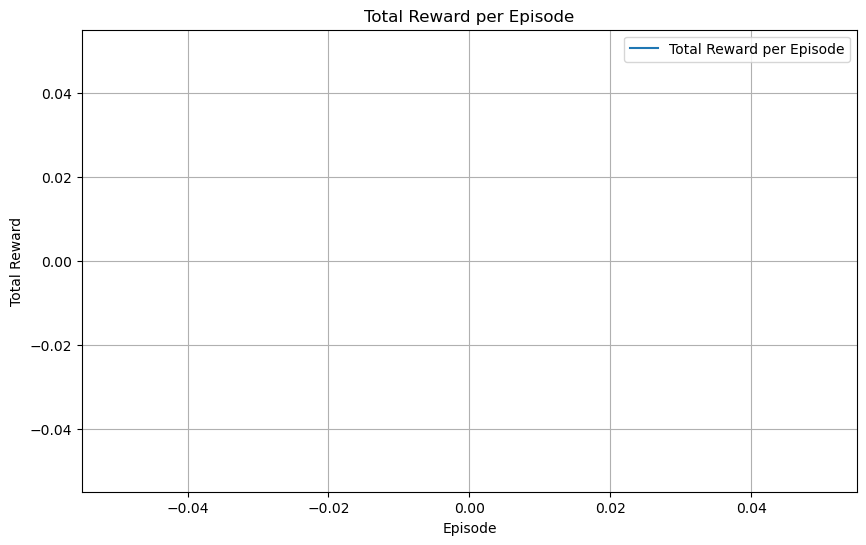

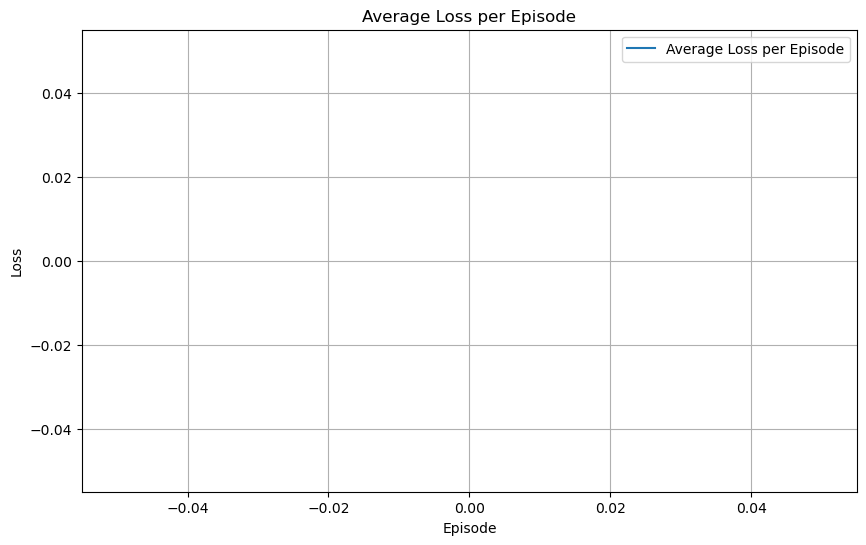

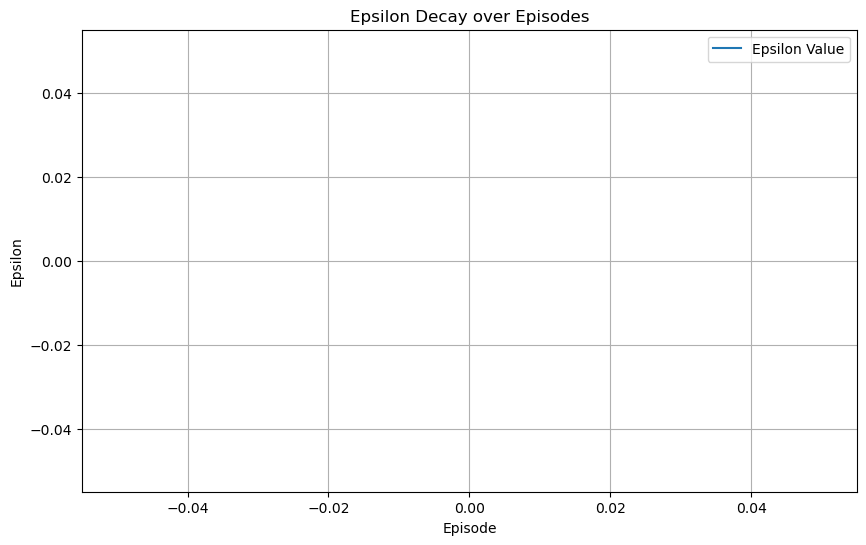

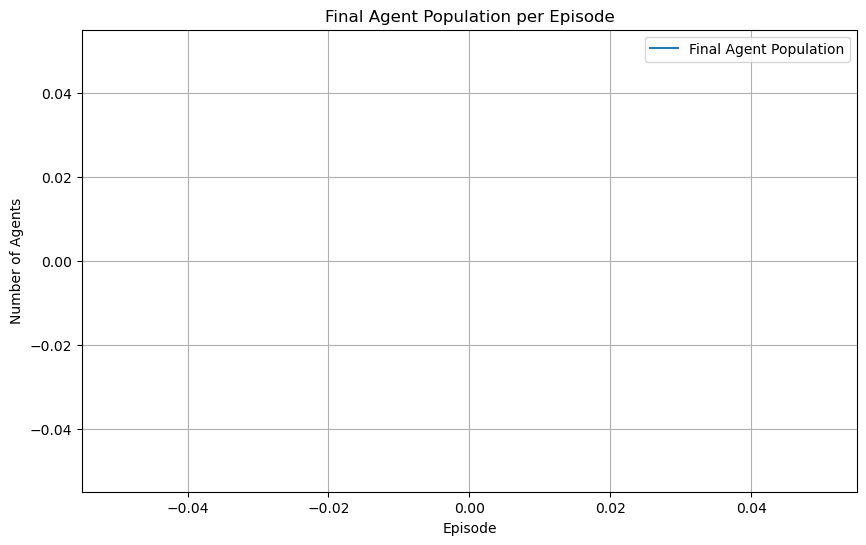

In [2]:
# visualization_code.py

import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
data = pd.read_csv('training_log.csv')

# Plot Total Reward per Episode
plt.figure(figsize=(10, 6))
plt.plot(data['Episode'], data['TotalReward'], label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.legend()
plt.grid(True)
plt.show()

# Plot Average Loss per Episode
plt.figure(figsize=(10, 6))
plt.plot(data['Episode'], data['Loss'], label='Average Loss per Episode')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Average Loss per Episode')
plt.legend()
plt.grid(True)
plt.show()

# Plot Epsilon Decay
plt.figure(figsize=(10, 6))
plt.plot(data['Episode'], data['Epsilon'], label='Epsilon Value')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay over Episodes')
plt.legend()
plt.grid(True)
plt.show()

# Plot Final Agent Population per Episode
plt.figure(figsize=(10, 6))
plt.plot(data['Episode'], data['FinalAgentPopulation'], label='Final Agent Population')
plt.xlabel('Episode')
plt.ylabel('Number of Agents')
plt.title('Final Agent Population per Episode')
plt.legend()
plt.grid(True)
plt.show()
